# Notebook 03 – Transformer Model Training & Evaluation

**Pipeline stages covered:**
1. Load pre-processed splits from Notebook 02
2. Build PyTorch DataLoaders
3. Instantiate Transformer classifier
4. Training loop with live progress
5. Loss & accuracy curves
6. Evaluation: Accuracy · Precision · Recall · F1-Score
7. Confusion matrix (raw + normalized)
8. Per-class metrics bar chart & radar chart
9. ROC curves (one-vs-rest)
10. Save model + all artifacts to `model/`

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import torch
# import torch_directml
import joblib
from sklearn.metrics import classification_report, confusion_matrix

from utils.model_utils import (
    TransformerClassifier,
    make_dataloaders,
    train_model,
    eval_epoch,
    compute_metrics,
    save_model,
)
from utils.visualization import (
    plot_training_history,
    plot_confusion_matrix,
    plot_evaluation_metrics,
    plot_metrics_radar,
    plot_roc_curves,
)

# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch_directml.is_available():
#     device = torch_directml.device()
# else:
#     device = torch.device("cpu")
device = torch.device("cpu")
print(f'✓ Imports OK  |  Device: {device}')

✓ Imports OK  |  Device: cpu


In [2]:
# ── Configuration ──────────────────────────────────────────────────────────
DATA_DIR   = '../data/processed'
MODEL_DIR  = '../model'

# Transformer hyperparameters
D_MODEL        = 128
N_HEADS        = 4
N_LAYERS       = 2
DIM_FEEDFORWARD= 256
DROPOUT        = 0.1

# Training hyperparameters
N_EPOCHS       = 10
BATCH_SIZE     = 512
LEARNING_RATE  = 1e-3
RANDOM_STATE   = 42

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
os.makedirs(MODEL_DIR, exist_ok=True)
print('Configuration set.')

Configuration set.


## 1 · Load Pre-processed Splits

In [3]:
with open(f'{DATA_DIR}/metadata.json') as f:
    meta = json.load(f)

class_names       = meta['class_names']
selected_features = meta['selected_features']
n_classes         = meta['n_classes']
n_features        = meta['n_features']

X_train = np.load(f'{DATA_DIR}/X_train_sc.npy')
X_test  = np.load(f'{DATA_DIR}/X_test_sc.npy')
y_train = np.load(f'{DATA_DIR}/y_train_enc.npy')
y_test  = np.load(f'{DATA_DIR}/y_test_enc.npy')

y_train_raw = pd.read_json(f'{DATA_DIR}/y_train_raw.json', typ='series')
y_test_raw  = pd.read_json(f'{DATA_DIR}/y_test_raw.json',  typ='series')

scaler        = joblib.load(f'{MODEL_DIR}/scaler.pkl')
label_encoder = joblib.load(f'{MODEL_DIR}/label_encoder.pkl')

print(f'Classes ({n_classes}): {class_names}')
print(f'Selected features ({n_features}): {selected_features}')
print(f'X_train: {X_train.shape}  y_train: {y_train.shape}')
print(f'X_test : {X_test.shape}   y_test : {y_test.shape}')

Classes (13): ['Benign', 'DrDoS_LDAP', 'DrDoS_MSSQL', 'DrDoS_NTP', 'DrDoS_NetBIOS', 'DrDoS_SNMP', 'DrDoS_SSDP', 'DrDoS_UDP', 'Portmap', 'Syn', 'TFTP', 'UDP-lag', 'WebDDoS']
Selected features (20): ['src_port', 'pkt_size_avg', 'fwd_pkt_len_max', 'pkt_len_mean', 'pkt_len_max', 'pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'totlen_fwd_pkts', 'dst_port', 'flow_byts_s', 'init_fwd_win_byts', 'tot_fwd_pkts', 'fwd_act_data_pkts', 'flow_pkts_s', 'fwd_pkts_s', 'protocol', 'fwd_iat_tot', 'fwd_iat_std', 'flow_duration']
X_train: (1900326, 20)  y_train: (1900326, 13)
X_test : (475082, 20)   y_test : (475082, 13)


## 2 · Build DataLoaders

In [4]:
train_loader, test_loader = make_dataloaders(
    X_train, y_train,
    X_test,  y_test,
    batch_size=BATCH_SIZE,
)
print(f'Train batches: {len(train_loader)}  |  Test batches: {len(test_loader)}')

Train batches: 3712  |  Test batches: 928


## 3 · Instantiate Transformer Classifier

In [5]:
model = TransformerClassifier(
    n_features=n_features,
    n_classes=n_classes,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    n_layers=N_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(model)
print(f'\nTrainable parameters: {total_params:,}')

TransformerClassifier(
  (input_proj): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=128, out_features

## 4 · Training

In [6]:
history = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    n_epochs=N_EPOCHS,
    lr=LEARNING_RATE,
    device=device,
    verbose=True,
)

Epoch   1/10 │ Train Loss: 0.0841  Acc: 0.6968 │ Val Loss: 0.0757  Acc: 0.7184 │ LR: 9.76e-04
Epoch   2/10 │ Train Loss: 0.0765  Acc: 0.7174 │ Val Loss: 0.0779  Acc: 0.7174 │ LR: 9.05e-04
Epoch   3/10 │ Train Loss: 0.0755  Acc: 0.7204 │ Val Loss: 0.0743  Acc: 0.7187 │ LR: 7.94e-04
Epoch   4/10 │ Train Loss: 0.0748  Acc: 0.7223 │ Val Loss: 0.0739  Acc: 0.7253 │ LR: 6.55e-04
Epoch   5/10 │ Train Loss: 0.0742  Acc: 0.7234 │ Val Loss: 0.0739  Acc: 0.7260 │ LR: 5.00e-04
Epoch   6/10 │ Train Loss: 0.0737  Acc: 0.7250 │ Val Loss: 0.0764  Acc: 0.7149 │ LR: 3.45e-04
Epoch   7/10 │ Train Loss: 0.0733  Acc: 0.7259 │ Val Loss: 0.0724  Acc: 0.7291 │ LR: 2.06e-04
Epoch   8/10 │ Train Loss: 0.0728  Acc: 0.7272 │ Val Loss: 0.0722  Acc: 0.7293 │ LR: 9.55e-05
Epoch   9/10 │ Train Loss: 0.0724  Acc: 0.7282 │ Val Loss: 0.0721  Acc: 0.7296 │ LR: 2.45e-05
Epoch  10/10 │ Train Loss: 0.0722  Acc: 0.7291 │ Val Loss: 0.0718  Acc: 0.7296 │ LR: 0.00e+00


## 5 · Training History

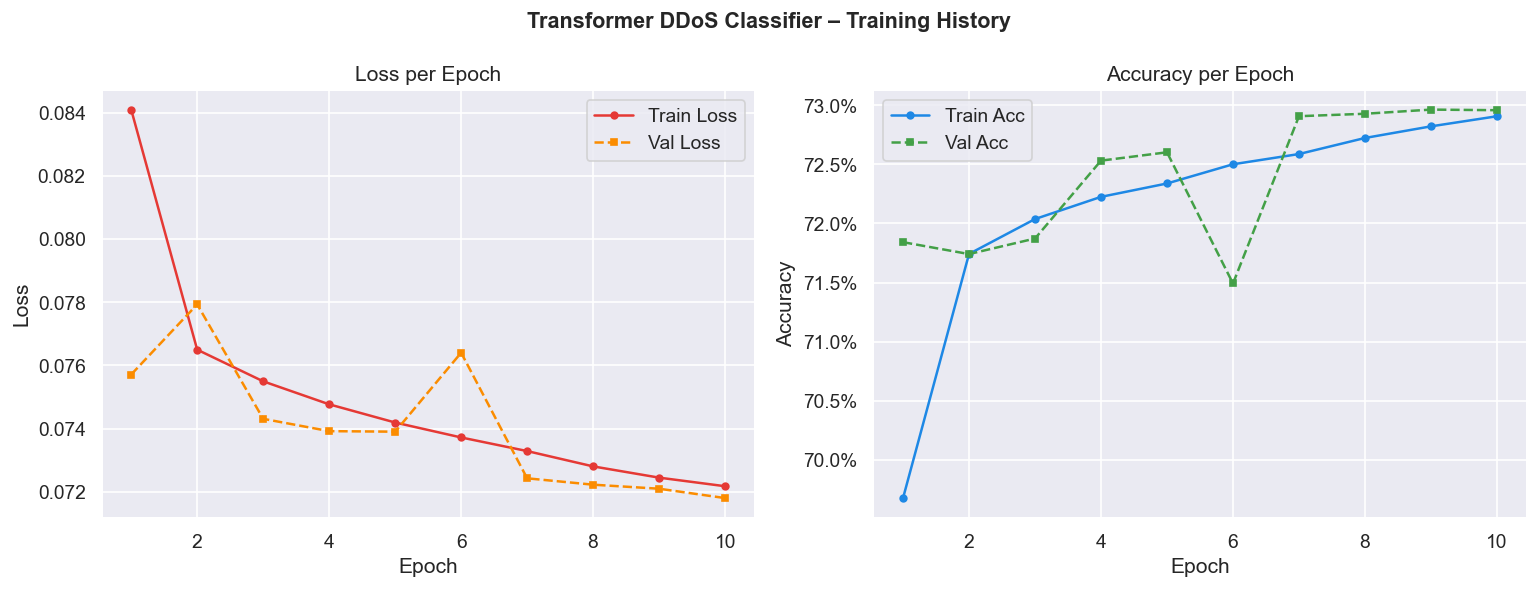

Best train acc : 0.7291
Best val acc   : 0.7296
Best val loss  : 0.0718


In [7]:
fig = plot_training_history(history, title='Transformer DDoS Classifier – Training History')
fig.savefig(f'{DATA_DIR}/fig_12_training_history.png', dpi=120, bbox_inches='tight')
plt.show()

best_train_acc = max(history['train_acc'])
best_val_acc   = max(history['val_acc'])
best_val_loss  = min(history['val_loss'])
print(f'Best train acc : {best_train_acc:.4f}')
print(f'Best val acc   : {best_val_acc:.4f}')
print(f'Best val loss  : {best_val_loss:.4f}')

## 6 · Final Evaluation on Test Set

In [8]:
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
test_loss, test_acc, y_pred_idx, y_true_idx, y_probs = eval_epoch(
    model, test_loader, criterion, device
)

print(f'Test Loss     : {test_loss:.4f}')
print(f'Test Accuracy : {test_acc:.4f}  ({test_acc*100:.2f}%)')

Test Loss     : 0.0718
Test Accuracy : 0.7296  (72.96%)


In [9]:
# Full classification report
metrics = compute_metrics(y_true_idx, y_pred_idx, class_names)

print('=== Classification Report ===')
print(classification_report(
    y_true_idx, y_pred_idx,
    target_names=class_names,
    digits=4,
    zero_division=0,
))

=== Classification Report ===
               precision    recall  f1-score   support

       Benign     0.9928    0.9994    0.9961     39972
   DrDoS_LDAP     0.8595    0.7012    0.7723     39923
  DrDoS_MSSQL     0.9509    0.9798    0.9652     39999
    DrDoS_NTP     0.9975    0.9954    0.9964     39999
DrDoS_NetBIOS     0.5173    0.9581    0.6718     39865
   DrDoS_SNMP     0.7268    0.8435    0.7808     39958
   DrDoS_SSDP     0.4626    0.0799    0.1362     40000
    DrDoS_UDP     0.4787    0.9170    0.6291     40000
      Portmap     0.5225    0.0394    0.0732     35433
          Syn     0.5891    0.9984    0.7409     39999
         TFTP     0.9950    0.9650    0.9798     39938
      UDP-lag     0.9757    0.2007    0.3330     39945
      WebDDoS     0.0000    0.0000    0.0000        51

     accuracy                         0.7296    475082
    macro avg     0.6976    0.6675    0.6211    475082
 weighted avg     0.7578    0.7296    0.6785    475082



## 7 · Confusion Matrix

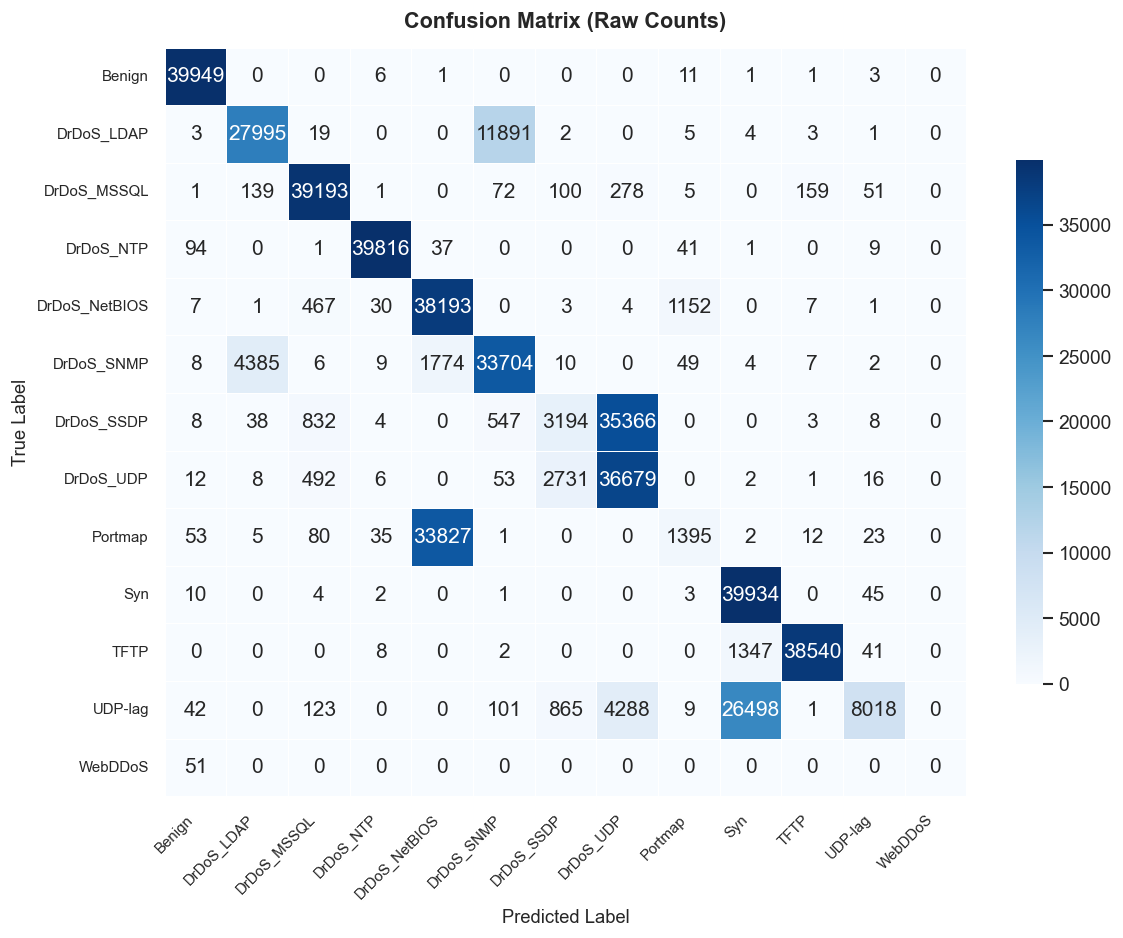

In [10]:
cm = metrics['confusion_matrix']

# Raw counts
fig = plot_confusion_matrix(cm, class_names,
                             title='Confusion Matrix (Raw Counts)',
                             normalize=False)
fig.savefig(f'{DATA_DIR}/fig_13_cm_raw.png', dpi=120, bbox_inches='tight')
plt.show()

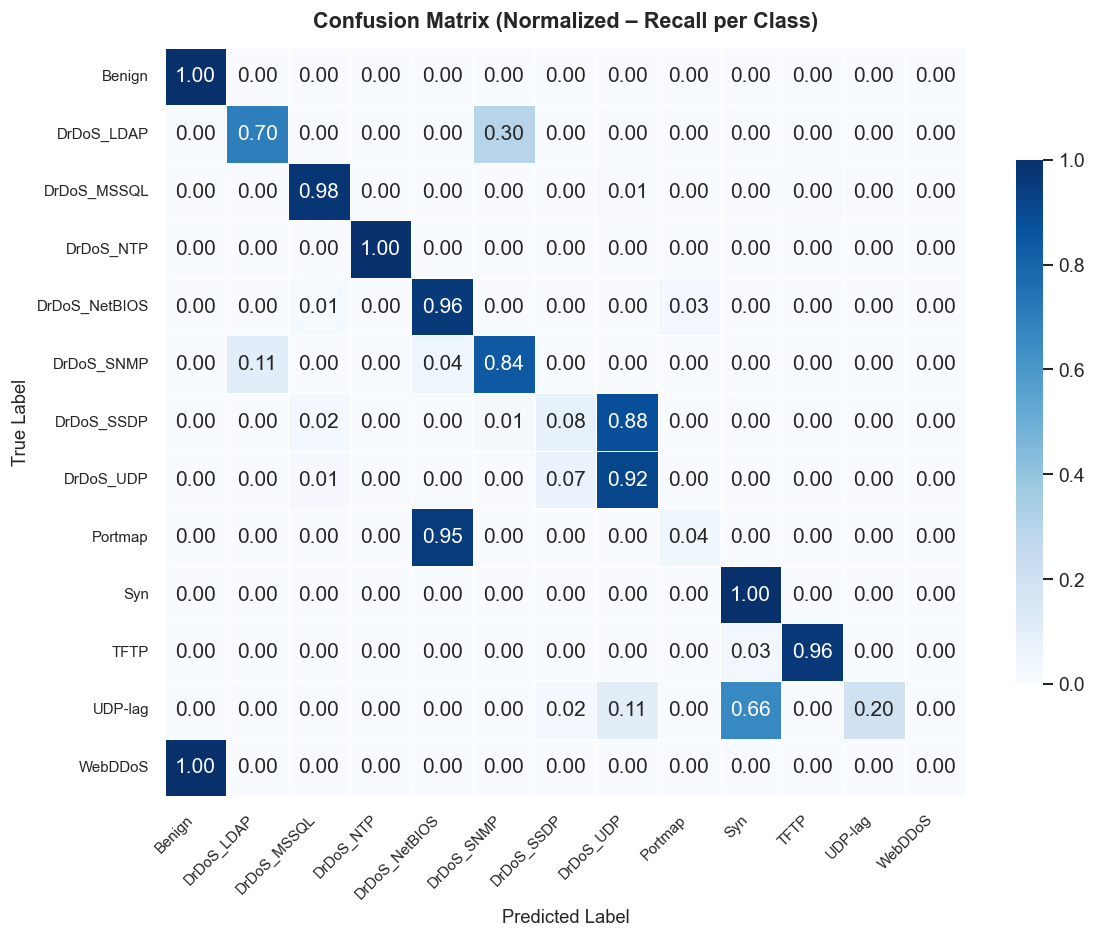

In [11]:
# Normalized (recall per class)
fig = plot_confusion_matrix(cm, class_names,
                             title='Confusion Matrix (Normalized – Recall per Class)',
                             normalize=True)
fig.savefig(f'{DATA_DIR}/fig_14_cm_normalized.png', dpi=120, bbox_inches='tight')
plt.show()

## 8 · Evaluation Metrics – Bar Chart & Radar Chart

In [12]:
# Summary table
skip_keys = {'accuracy', 'macro avg', 'weighted avg', 'confusion_matrix'}
metrics_table = {
    cls: {k: round(v, 4) for k, v in vals.items() if k != 'support'}
    for cls, vals in metrics.items()
    if cls not in skip_keys
}
metrics_table['accuracy'] = round(metrics['accuracy'], 4)
metrics_table['macro avg']    = {k: round(v, 4) for k, v in metrics['macro avg'].items()    if k != 'support'}
metrics_table['weighted avg'] = {k: round(v, 4) for k, v in metrics['weighted avg'].items() if k != 'support'}

summary_df = pd.DataFrame(metrics_table).T
print('=== Metrics Summary ===')
display(summary_df.style.background_gradient(cmap='RdYlGn', axis=None, vmin=0, vmax=1))

=== Metrics Summary ===


,precision,recall,f1-score
Benign,0.992800,0.999400,0.996100
DrDoS_LDAP,0.859500,0.701200,0.772300
DrDoS_MSSQL,0.950900,0.979800,0.965200
DrDoS_NTP,0.997500,0.995400,0.996400
DrDoS_NetBIOS,0.517300,0.958100,0.671800
DrDoS_SNMP,0.726800,0.843500,0.780800
DrDoS_SSDP,0.462600,0.079900,0.136200
DrDoS_UDP,0.478700,0.917000,0.629100
Portmap,0.522500,0.039400,0.073200
Syn,0.589100,0.998400,0.740900


In [17]:
# Grouped bar chart: Precision, Recall, F1 per class
fig = plot_evaluation_metrics(
    metrics,
    title='Per-Class Metrics: Precision · Recall · F1-Score  |  Overall Accuracy'
)
fig.savefig(f'{DATA_DIR}/fig_15_metrics_bar.png', dpi=120, bbox_inches='tight')
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Radar chart
fig = plot_metrics_radar(metrics, title='Per-Class Precision / Recall / F1 Radar')
fig.savefig(f'{DATA_DIR}/fig_16_metrics_radar.png', dpi=120, bbox_inches='tight')
plt.show()

## 9 · ROC Curves (One-vs-Rest)

In [ ]:
fig = plot_roc_curves(
    y_true_onehot=y_test,
    y_prob=y_probs,
    class_names=class_names,
    title='ROC Curves – Transformer DDoS Classifier (One-vs-Rest)',
)
fig.savefig(f'{DATA_DIR}/fig_17_roc_curves.png', dpi=120, bbox_inches='tight')
plt.show()

## 10 · Per-Epoch Accuracy & Loss Summary Table

In [ ]:
history_df = pd.DataFrame(history)
history_df.index = history_df.index + 1
history_df.index.name = 'Epoch'

# Highlight best epochs
display(
    history_df.style
    .highlight_max(subset=['train_acc', 'val_acc'], color='#C8E6C9')
    .highlight_min(subset=['train_loss', 'val_loss'], color='#BBDEFB')
    .format('{:.4f}')
)

## 11 · Save Model & Artifacts

In [ ]:
save_model(
    model=model,
    scaler=scaler,
    label_encoder=label_encoder,
    selected_features=selected_features,
    model_dir=MODEL_DIR,
)

print('\n=== Saved Artifacts ===')
for root, dirs, files in os.walk(MODEL_DIR):
    for fname in files:
        fpath = os.path.join(root, fname)
        size  = os.path.getsize(fpath)
        print(f'  {fname:<35}  {size/1024:.1f} KB')

In [ ]:
# Final summary
print('=' * 55)
print('  FINAL MODEL SUMMARY')
print('=' * 55)
print(f'  Architecture  : Transformer ({N_LAYERS} layers, {N_HEADS} heads, d={D_MODEL})')
print(f'  Input features: {n_features}')
print(f'  Output classes: {n_classes}')
print(f'  Epochs trained: {N_EPOCHS}')
print(f'  Test Accuracy : {test_acc*100:.2f}%')
print(f'  Macro F1      : {metrics["macro avg"]["f1-score"]*100:.2f}%')
print(f'  Weighted F1   : {metrics["weighted avg"]["f1-score"]*100:.2f}%')
print('=' * 55)